In [1]:
import pandas as pd
from functions import calc, retrieve, visualize as viz

import warnings
warnings.filterwarnings('ignore')


In [8]:
def get_and_store_raw_data(fromCSV, numberOfStocks=50, daysSince=30):
    if (fromCSV):
        print ("Returning stored data.")
        (rawdata, spreads, volumes) = ((pd.read_csv('data/close.csv')).set_index('Date'),
                            (pd.read_csv('data/spreads.csv')).set_index('Date'),
                            (pd.read_csv('data/volumes.csv')).set_index('Date'))
    else:
        downloadedData = retrieve.get_downloaded_data(numberOfStocks, daysSince)
        rawdata = downloadedData['Close']
        spreads = (downloadedData['High'] - downloadedData['Low'])/(downloadedData['Close'])
        volumes = downloadedData['Volume']
        rawdata.to_csv('./data/close.csv')
        spreads.to_csv('./data/spreads.csv')
        volumes.to_csv('./data/volumes.csv')

    return (rawdata, spreads, volumes)
    
def processData(rawdata, QUICK_EMA_PERIOD=7, SLOW_EMA_PERIOD=14, latestWindow=2):
    
    companies = rawdata.columns.values

    EMA_df = calc.get_EMA_df(QUICK_EMA_PERIOD, SLOW_EMA_PERIOD, rawdata)
    keyStats = calc.get_intersection_point(EMA_df, rawdata)
    (keyStats['avgRatio'], keyStats['MinAbsRatio']) = calc.ratioWrapper(EMA_df, companies, keyStats)
    keyStats['latestGrowth'] = round(rawdata.pct_change()[-latestWindow:].min(),5)
    keyStats['ratioContr'] = calc.get_stocks_growing_now(rawdata, keyStats, 3)

    return(EMA_df, keyStats) 

def showData(rawdata, EMA_df, keyStats, filterSet):
    filteredCompanies = viz.filter_companies(keyStats, filterSet)
    filteredCompanies.to_csv("./logs/filteredCompanies_" + pd.to_datetime('today').strftime('%Y%m%d')) 
    viz.plot_all(rawdata, EMA_df, filteredCompanies, limit=20)


In [17]:
"""
Filterset Sample. Use 0 or comment for Neutral

filterSet = dict({
    "aboveAvgRatio":1, 
    "aboveMinAbs":1, 
    "minPositivePeriod":4, 
    "ratioContr":1, 
    "latestGrowth":0.8
    })

timeframes dict({
    daysSince,
    qema_period,
    sema_period
    }) 
"""

filterSet = dict({
    #"aboveAvgRatio":0.02, 
    "aboveMinAbs":0.0001, 
    #"minPositivePeriod":4, 
    #"ratioContr":1,
    "latestGrowth":0.005
     })

def find_stocks(filterSet, numberOfStocks=500):
    (closes, spreads, volumes)= get_and_store_raw_data(fromCSV='keyStats' in globals(), numberOfStocks=numberOfStocks, daysSince=30)
    (EMA_df, keyStats) = processData(closes, QUICK_EMA_PERIOD=7, SLOW_EMA_PERIOD=14, latestWindow=2)
    showData(closes, EMA_df, keyStats, filterSet)
    return (closes, spreads, volumes, EMA_df, keyStats)

#(closes, spreads, EMA_df, keyStats) = find_stocks(filterSet)



In [4]:
(ts_today, ts_origin) = retrieve.get_timestamps(2)

Requested days: 30.
Requested stocks: 500.
[*********************100%***********************]  500 of 500 completed
EMA Dataframe calculated.
Intersection points found.
Absolute and Relative Mins calculated.
Main companies filtered. 481 outstanding companies.
Displaying 20 first companies
Company RCL


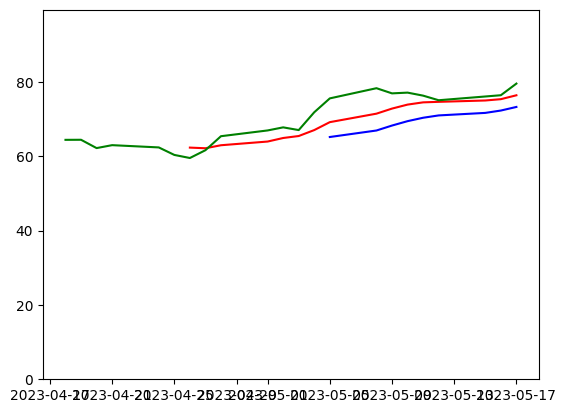

Company LYV


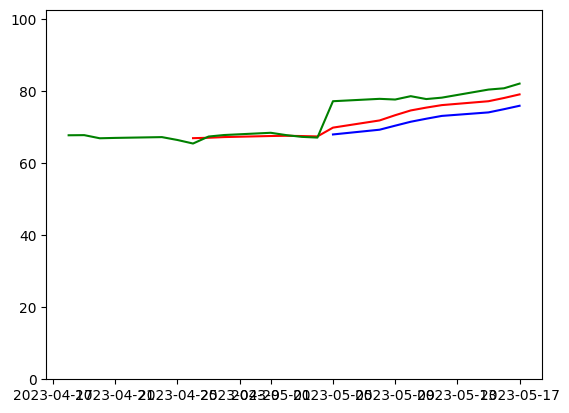

Company HAS


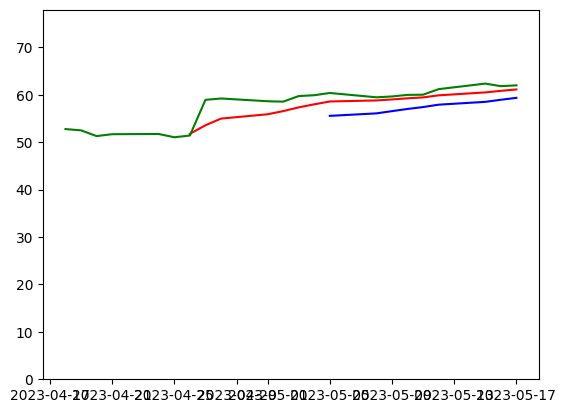

Company LLY


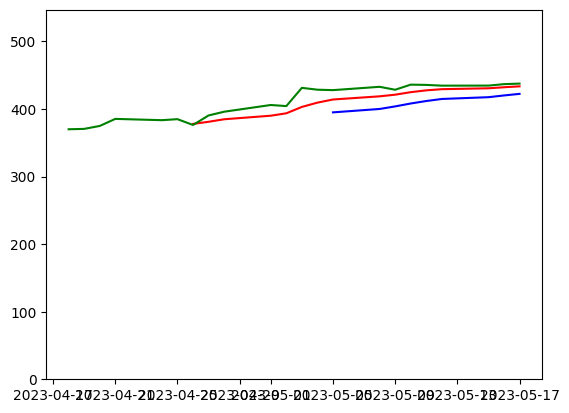

Company VMC


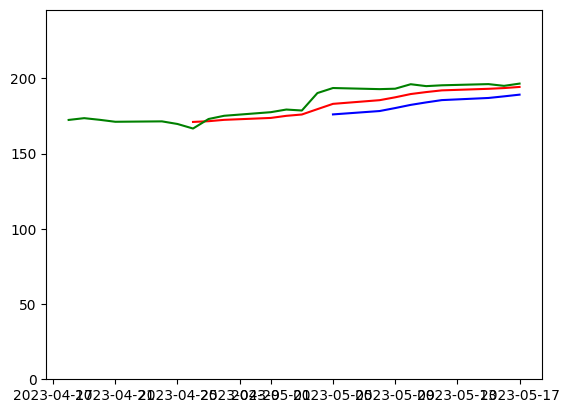

Company MLM


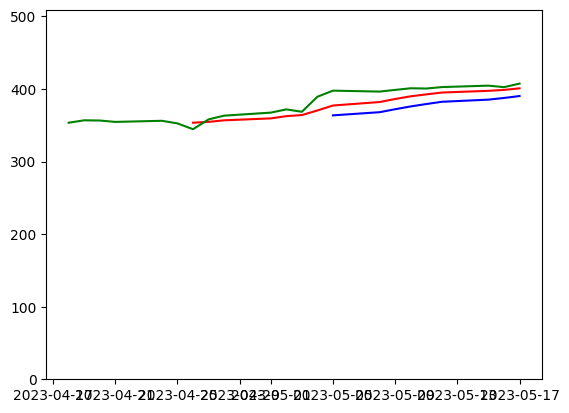

Company GNRC


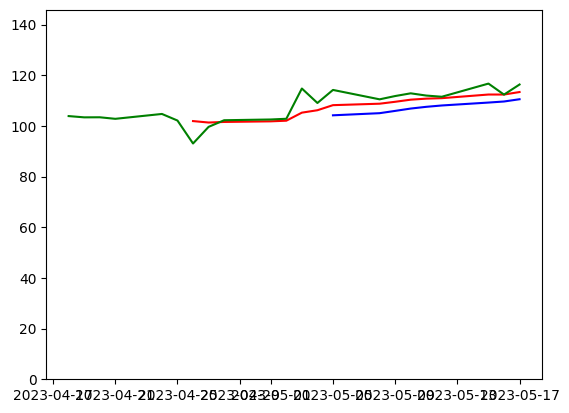

Company AIZ


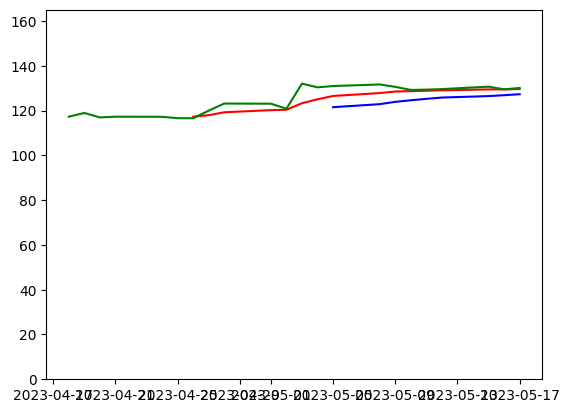

Company TAP


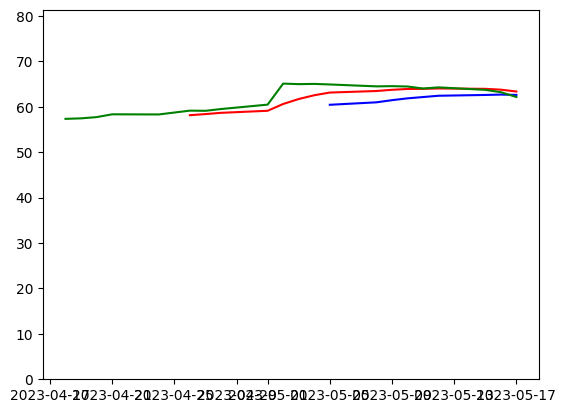

Company MNST


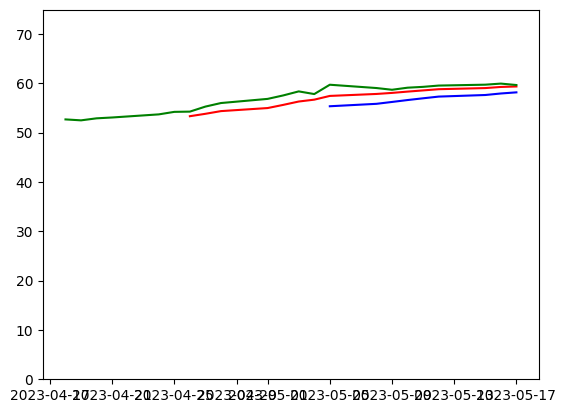

Company VRSK


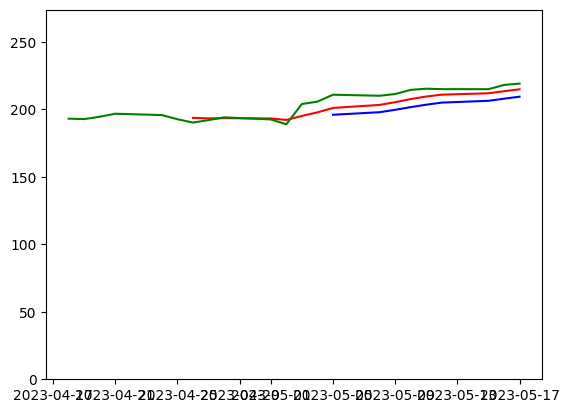

Company BALL


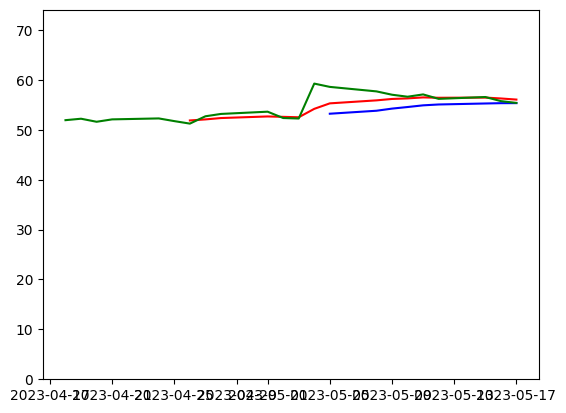

Company CMG


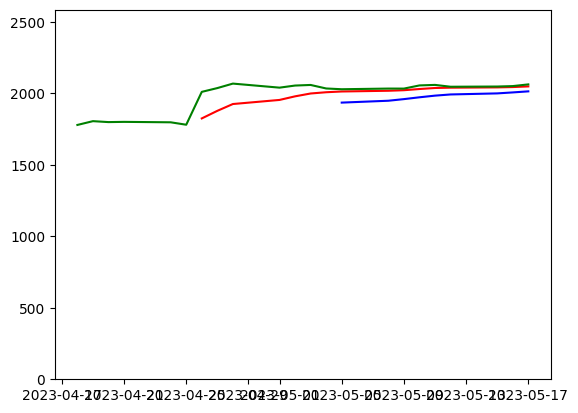

Company CCL


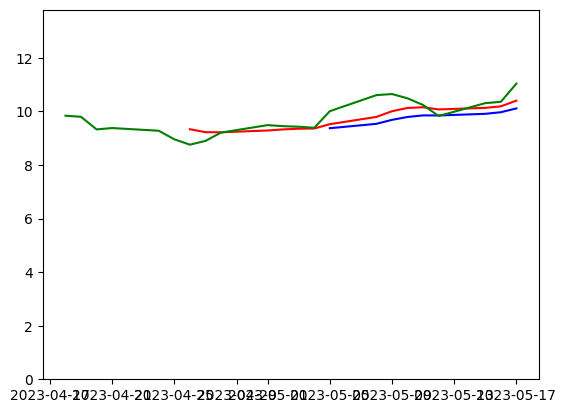

Company ON


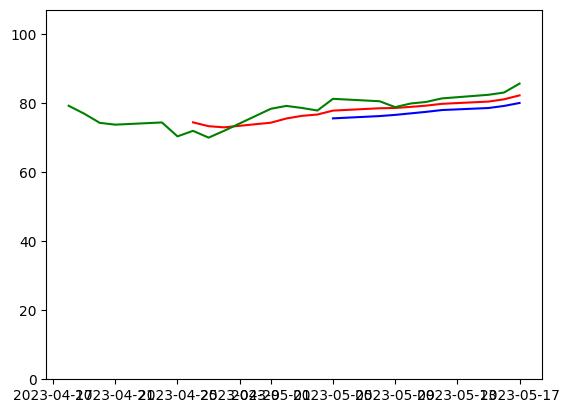

Company DVA


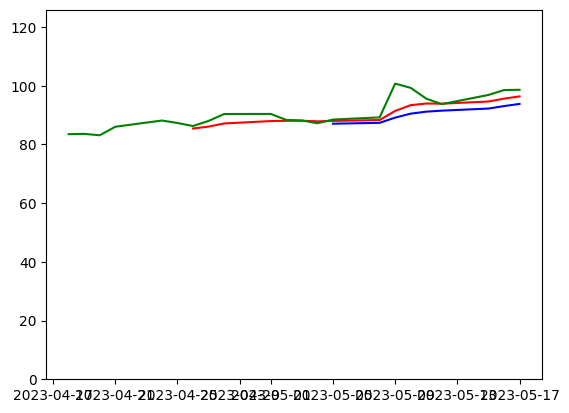

Company PNR


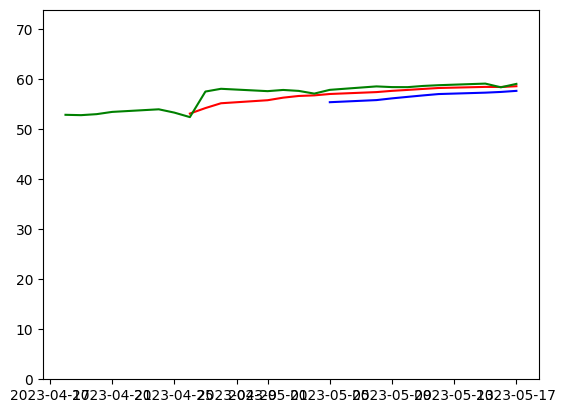

Company META


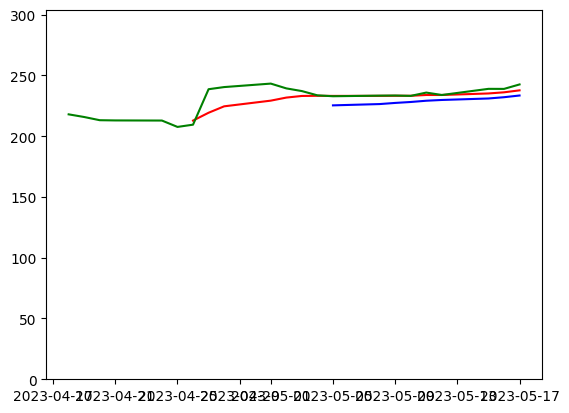

Company MDLZ


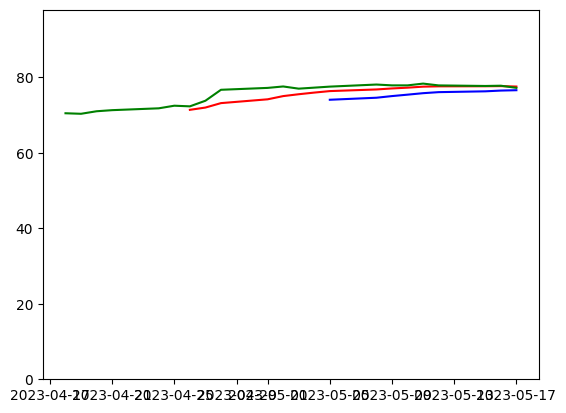

Company AMD


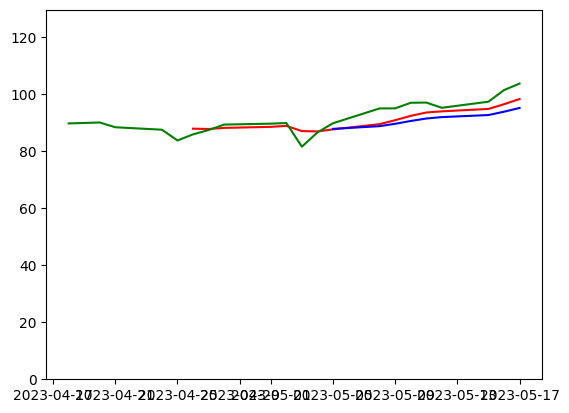

In [18]:
#if 'keyStats' in globals(): del(keyStats)
(closes, spreads, volumes, EMA_df, keyStats) = find_stocks(dict({
    #"aboveAvgRatio":0.02, 
    "aboveMinAbs":0, #Originally 0.0001 
    #"minPositivePeriod":4, 
    #"ratioContr":1,
    "latestGrowth":-5 #Originally 0.005
     }))

In [19]:
OBV_df= calc.get_OBV_df(volumes, closes)

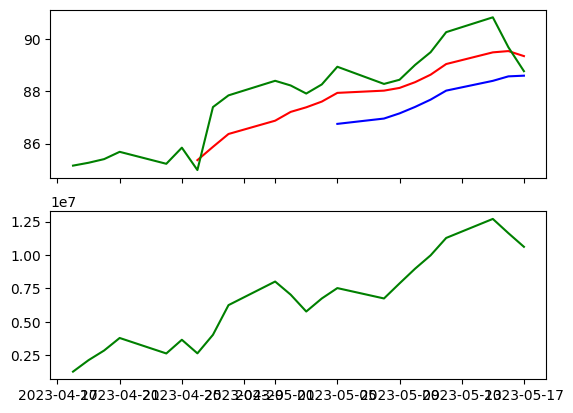

In [20]:
import matplotlib.pyplot as plt
testcompany = 'MKC'

#def plot_one_with_obv(testcompany):
fig, axs = (plt.subplots(2, sharex=True))
#axs[0].set_facecolor('green')
x_axis = closes.index
axs[0].plot(x_axis, EMA_df['Quick'][testcompany], 'r')
axs[0].plot(x_axis, EMA_df['Slow'][testcompany], 'b')
axs[0].plot(x_axis, closes[testcompany], 'g')
axs[1].plot(x_axis, OBV_df[testcompany], 'g')
